# Install and Import Packages

In [13]:
# Importing Libraries

In [14]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
!pip install json-tricks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
!pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit 


import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import time
tic = time.perf_counter()
import IPython.display as ipd

import matplotlib

# Dataset 

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
#Crema = "/content/drive/MyDrive/datasets/speech/CREMAD/sample/"
#Crema = "/content/drive/MyDrive/datasets/speech/CREMAD/AudioWAV/"
Ravdess = "/content/drive/MyDrive/datasets/speech/RAVDESS/data/Audio_Speech_Actors_01-24"
Ravdess_processed = "/content/drive/MyDrive/datasets/speech/RAVDESS/processedData/onlySpeech/"
Ravdess_speech_sample = "/content/drive/MyDrive/datasets/speech/RAVDESS/data/Audio_Speech_Actors_01-24/"
df_path = "/content/drive/MyDrive/datasets/speech/RAVDESS/ravdess_df_onlySpeech.csv"

In [21]:
# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotion_encode(e_num):
    if e_num == "01":   return 7 # neutral
    elif e_num == "02": return 0 # calm
    elif e_num == "03": return 1 # happy
    elif e_num == "04": return 2 # sad
    elif e_num == "05": return 3 # angry
    elif e_num == "06": return 4 # fear
    elif e_num == "07": return 5 # disgust
    else:               return 6 # suprised

def emotion_label(e):
  labels = ["calm", "happy", "sad", "angry", "fear", "disgust", "suprised", "neutral"]
  return labels[e]

In [22]:
labels = ["neutral", "calm", "happy", "sad", "angry", "fear", "disgust", "suprised"]
labels

['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'suprised']

In [23]:
 os.walk(Ravdess)

<generator object walk at 0x7f9d404066d0>

# Visualization

In [42]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 



#e = emotion_encode(e_num)
#labels[e]
#X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
#mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# Audio waveplot
def create_waveplot(path):
    e_num = path[len(Ravdess_speech_sample + actor) +  + 6: len(Ravdess_speech_sample + actor) + 8]
    e = labels[emotion_encode(e_num)]
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion audio sampled at 44100 hrz'.format(e), size=15)
    librosa.display.waveplot(X, sr= sample_rate)
    plt.show()

# Spectogram without logarithmic scale 
def create_spectrogram_nonlog(path):
    e_num = path[len(Ravdess_speech_sample + actor) +  + 6: len(Ravdess_speech_sample + actor) + 8]
    e = labels[emotion_encode(e_num)]
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    Y = librosa.stft(X)
    #Xdb = librosa.amplitude_to_db(abs(Y))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Y, sr=sample_rate, x_axis='time', y_axis='hz')   
    plt.colorbar()
    plt.show()


# Spectogram
def create_spectrogram(path):
    e_num = path[len(Ravdess_speech_sample + actor) +  + 6: len(Ravdess_speech_sample + actor) + 8]
    e = labels[emotion_encode(e_num)]
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    X = librosa.stft(X)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion (in DB amplitude and Hz scale)'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')   
    plt.colorbar()
    plt.show()

 
# Mel-Spectogram
def create_mel_spectrogram(path):
    e_num = path[len(Ravdess_speech_sample + actor) +  + 6: len(Ravdess_speech_sample + actor) + 8]
    e = labels[emotion_encode(e_num)]
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    mel_spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate)
    print("Spectrogram's Shape: ",mel_spectrogram.shape)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    print("Mel-Spectrogram's Shape: ",log_mel_spectrogram.shape)
    plt.figure(figsize=(12, 3))
    plt.title('Mel-Spectrogram for {} emotion (in DB amplitude and mel-scale'.format(e), size=15)
    librosa.display.specshow(log_mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')   
    plt.colorbar()
    plt.show()
   


# MFCC Plot
def mfcc_plot(path):
    e_num = path[len(Ravdess_speech_sample + actor) +  + 6: len(Ravdess_speech_sample + actor) + 8]
    e = labels[emotion_encode(e_num)]
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    plt.figure(figsize=(20, 15))
    plt.subplot(3,1,1)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.title('mfcc plot for {} emotion audio'.format(e), size=15)
    plt.ylabel('MFCC')
    plt.colorbar()
    plt.show()


# Frequency Plot
def freq_plot(path):
    e_num = path[len(Ravdess_speech_sample + actor) +  + 6: len(Ravdess_speech_sample + actor) + 8]
    e = labels[emotion_encode(e_num)]
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    D = np.abs(librosa.stft(y = X, center=False,))
    plt.figure(figsize=(20, 15))
    plt.subplot(3,1,1)
    #librosa.display.specshow(mfcc, x_axis='time')
    plt.magnitude_spectrum(X, Fs = sample_rate, color='C1', window=matplotlib.mlab.window_none)
    plt.xlim(0, 600)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [-]')
    plt.tight_layout()
    plt.show()


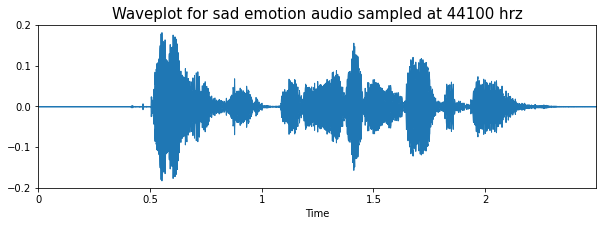

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


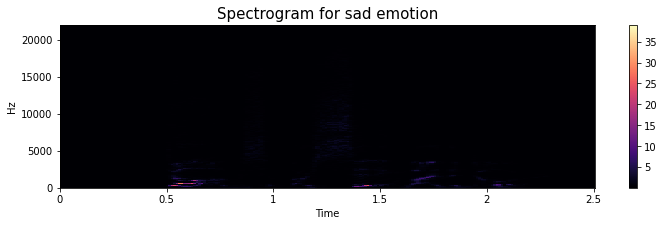

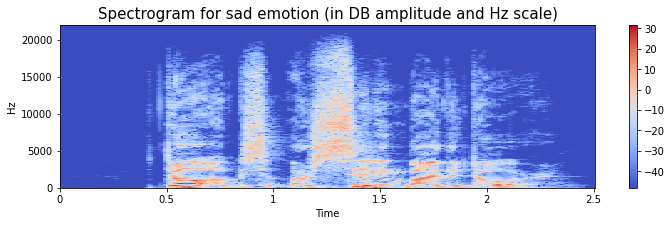

Spectrogram's Shape:  (128, 216)
Mel-Spectrogram's Shape:  (128, 216)


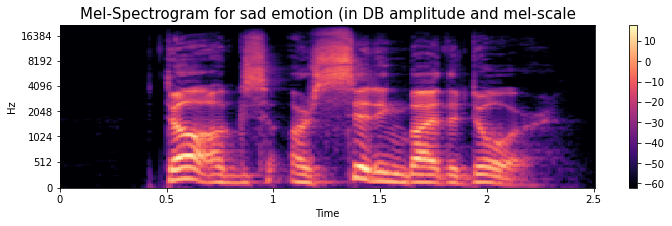

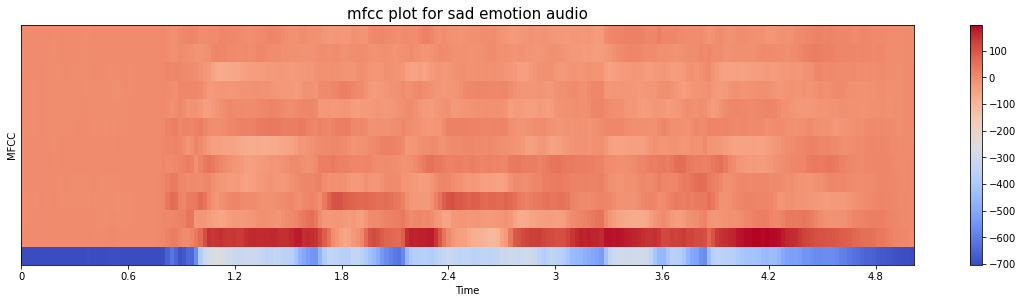

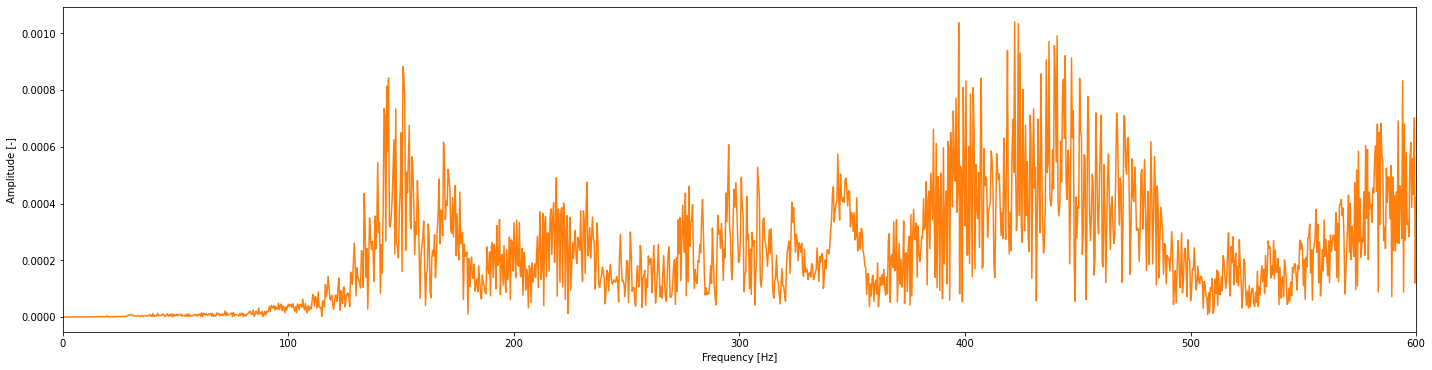

In [43]:
# Source - RAVDESS; Gender - Male; Emotion - Angry; Intensity: Normal
actor = "Actor_01/"
sample = "03-01-05-01-02-02-01.wav"
path = Ravdess_speech_sample + actor + sample
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

create_waveplot(path)
create_spectrogram_nonlog(path)
create_spectrogram(path)
create_mel_spectrogram(path)
mfcc_plot(path)
freq_plot(path)
ipd.Audio(path)

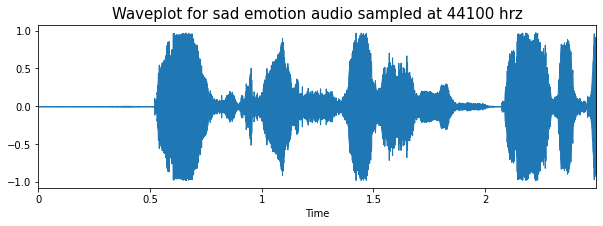

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


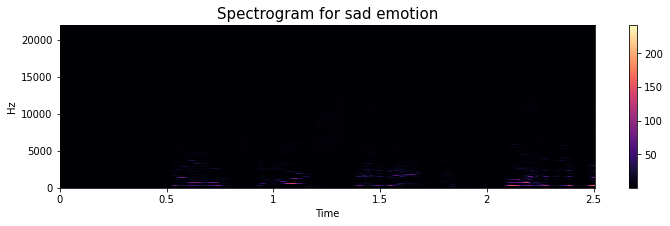

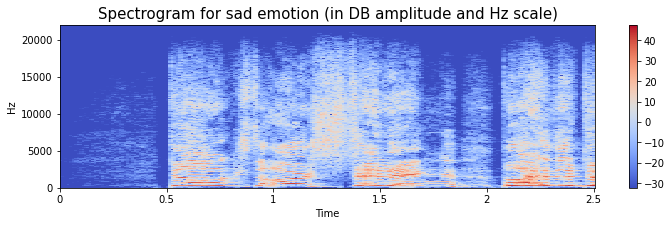

Spectrogram's Shape:  (128, 216)
Mel-Spectrogram's Shape:  (128, 216)


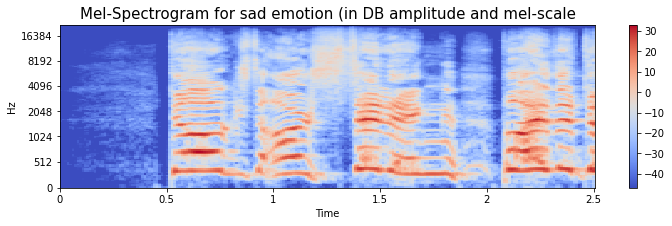

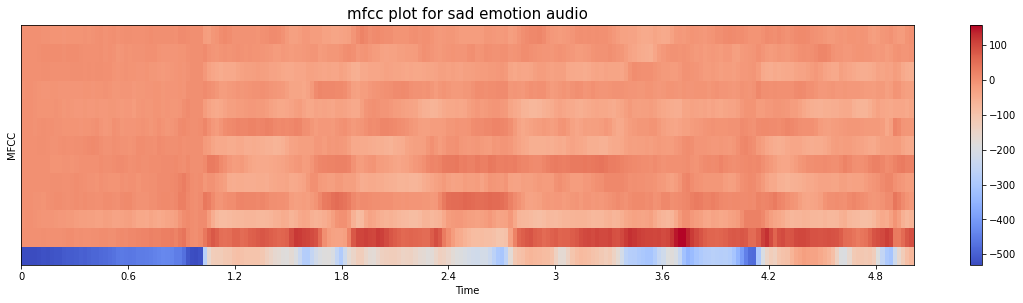

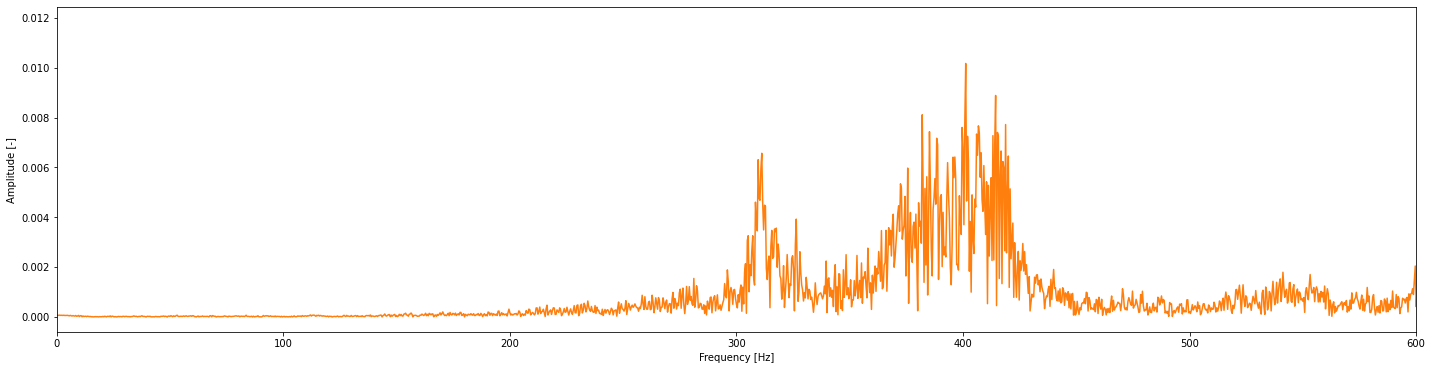

In [44]:
# Source - RAVDESS; Gender - Male; Emotion - Angry; Intensity: Intense
actor = "Actor_01/"
sample = "03-01-05-02-02-02-01.wav"
path = Ravdess_speech_sample + actor + sample
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

create_waveplot(path)
create_spectrogram_nonlog(path)
create_spectrogram(path)
create_mel_spectrogram(path)
mfcc_plot(path)
freq_plot(path)
ipd.Audio(path)

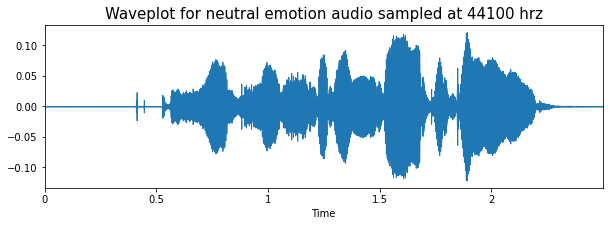

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


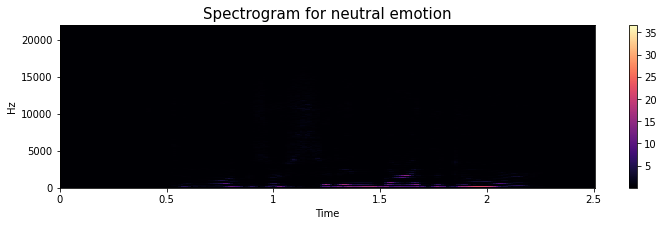

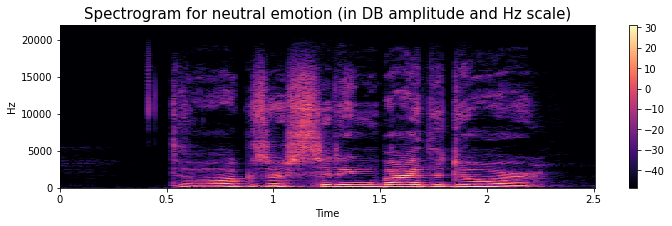

Spectrogram's Shape:  (128, 216)
Mel-Spectrogram's Shape:  (128, 216)


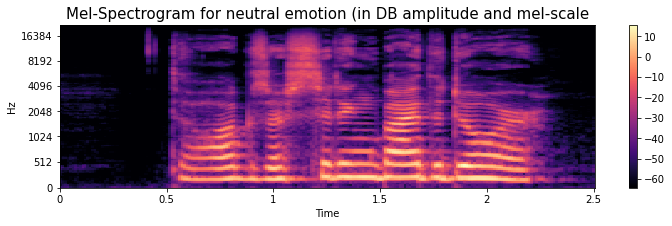

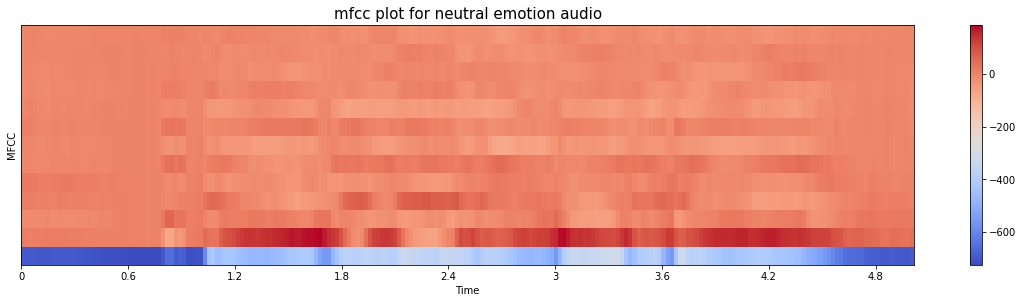

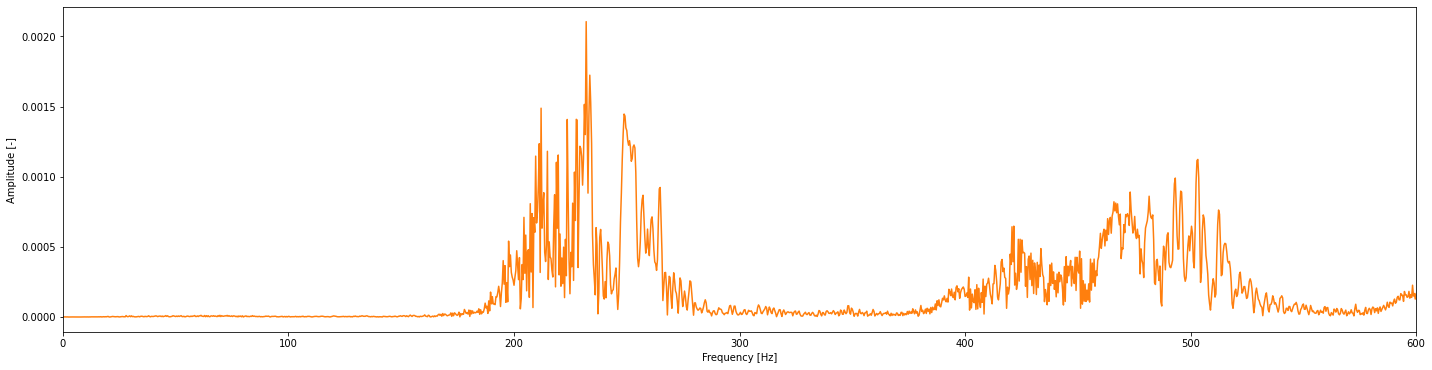

In [45]:
# Source - RAVDESS; Gender - Female; Emotion - Calm; Intensity: Normal
actor = "Actor_10/"
sample = "03-01-02-01-02-02-10.wav"
path = Ravdess_speech_sample + actor + sample
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

create_waveplot(path)
create_spectrogram_nonlog(path)
create_spectrogram(path)
create_mel_spectrogram(path)
mfcc_plot(path)
freq_plot(path)
ipd.Audio(path)

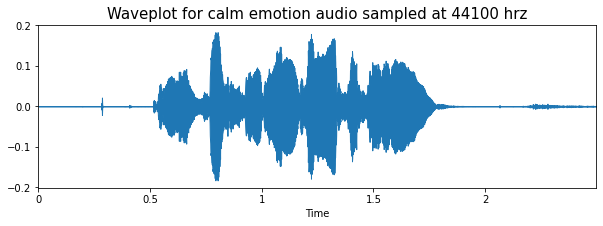

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


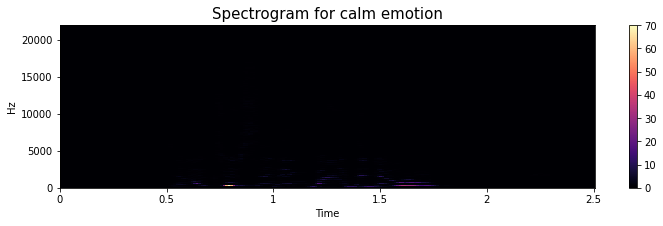

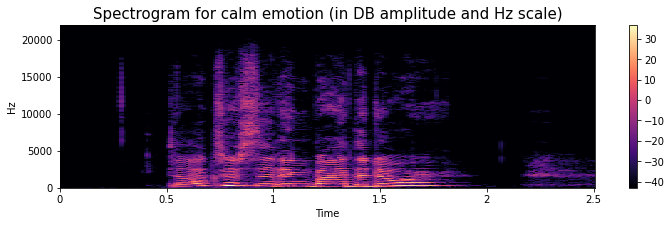

Spectrogram's Shape:  (128, 216)
Mel-Spectrogram's Shape:  (128, 216)


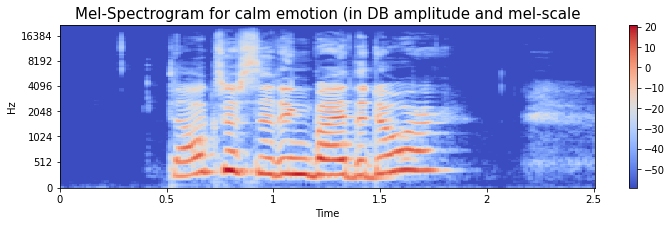

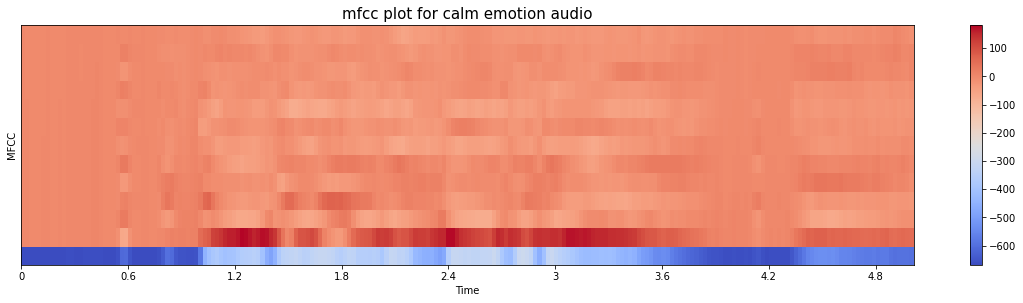

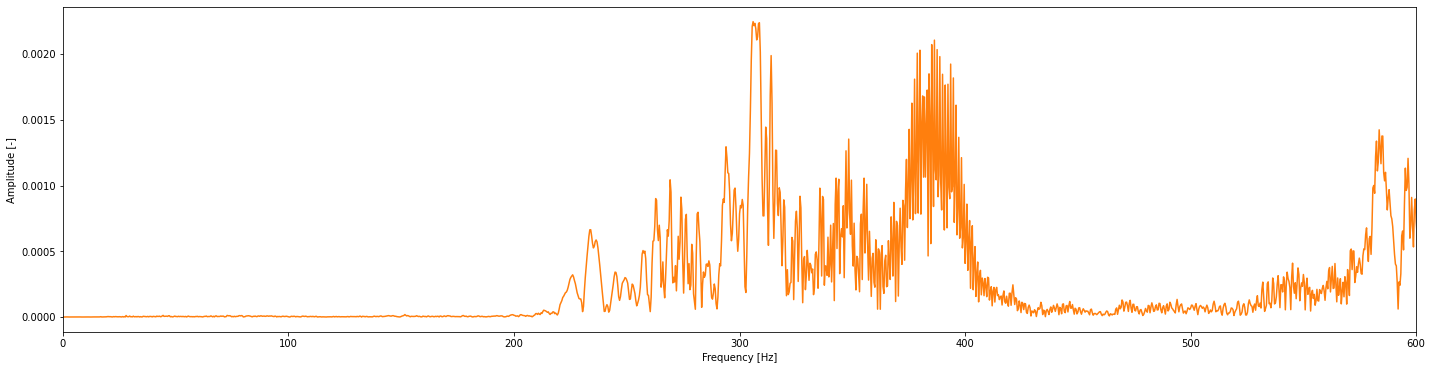

In [46]:
# Source - RAVDESS; Gender - Female; Emotion - Happy; Intensity: Normal
actor = "Actor_10/"
sample = "03-01-03-01-02-01-10.wav"
path = Ravdess_speech_sample + actor + sample
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

create_waveplot(path)
create_spectrogram_nonlog(path)
create_spectrogram(path)
create_mel_spectrogram(path)
mfcc_plot(path)
freq_plot(path)
ipd.Audio(path)

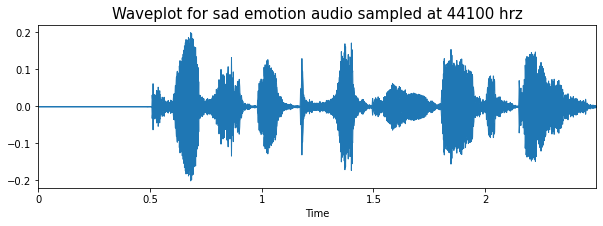

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


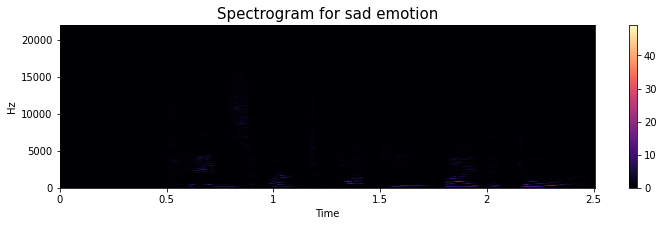

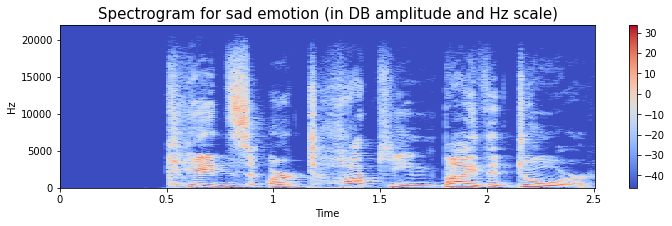

Spectrogram's Shape:  (128, 216)
Mel-Spectrogram's Shape:  (128, 216)


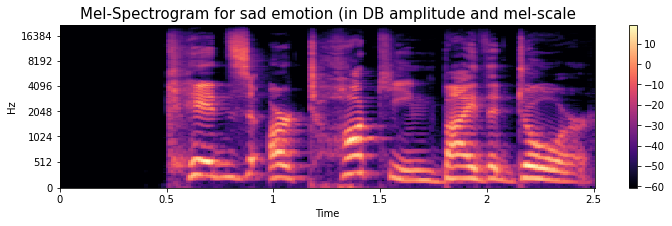

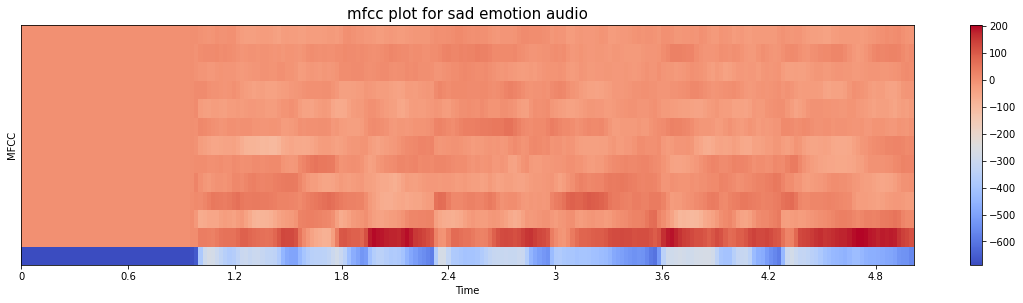

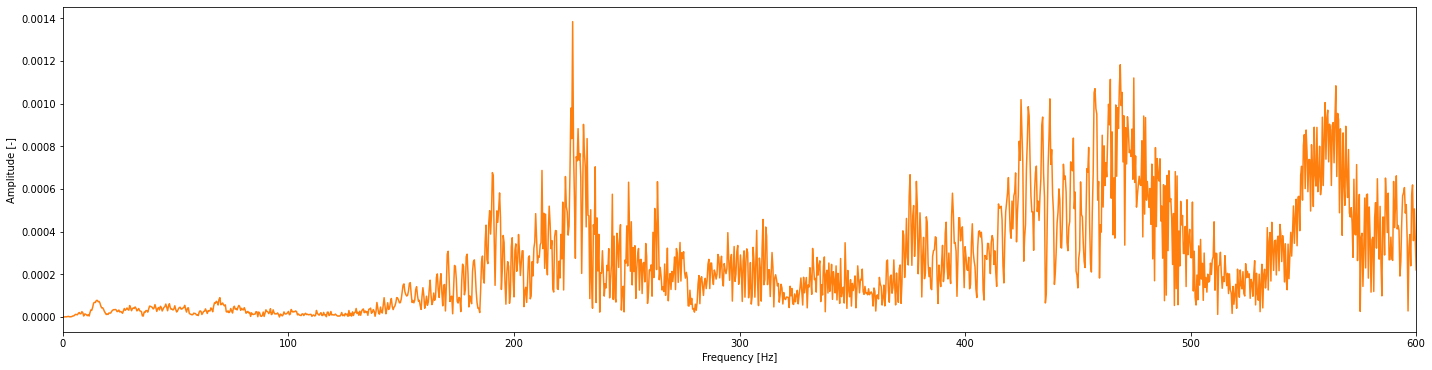

In [47]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
actor = "Actor_16/"
sample = "03-01-05-01-01-01-16.wav"
path = Ravdess_speech_sample + actor + sample
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

create_waveplot(path)
create_spectrogram_nonlog(path)
create_spectrogram(path)
create_mel_spectrogram(path)
mfcc_plot(path)
freq_plot(path)
ipd.Audio(path)

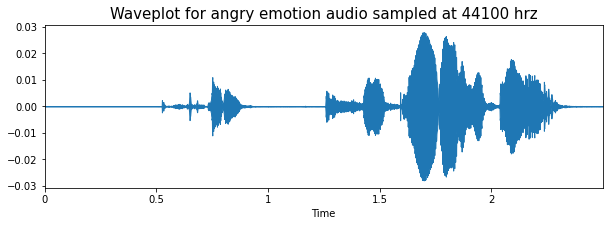

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


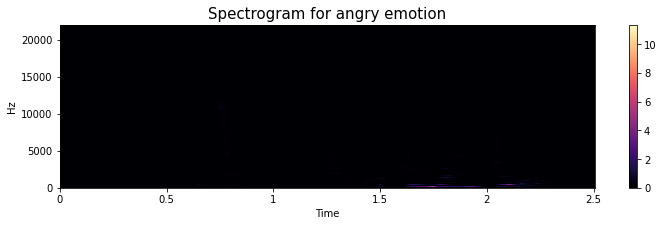

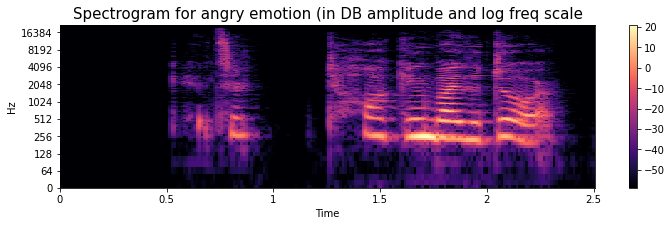

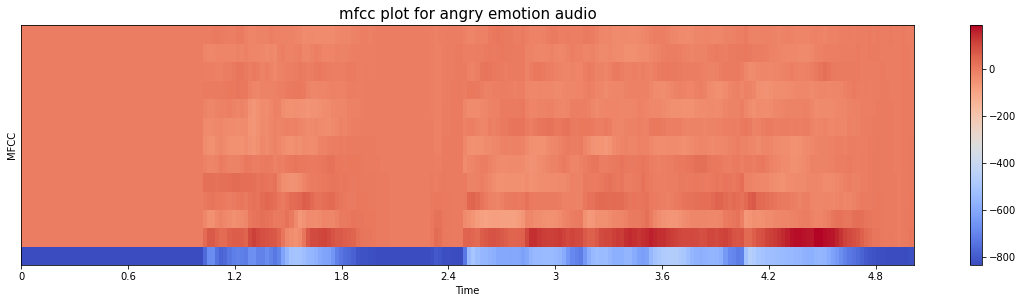

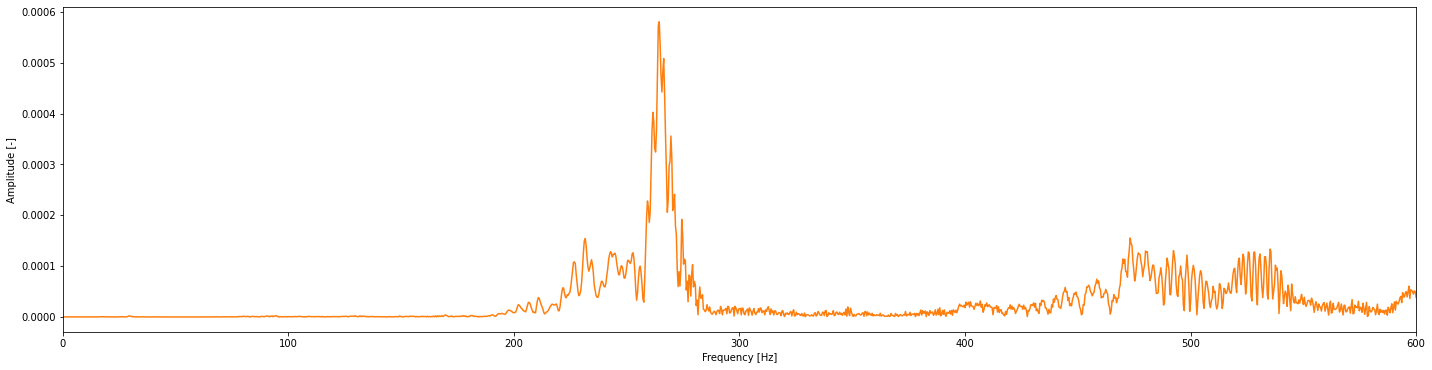

In [48]:
# Source - RAVDESS; Gender - Male; Emotion - Fear 
actor = "Actor_20/"
sample = "03-01-06-01-01-01-20.wav"
path = Ravdess_speech_sample + actor + sample
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

create_waveplot(path)
create_spectogram_nonlog(path)
create_spectogram(path)
mfcc_plot(path)
freq_plot(path)
ipd.Audio(path)

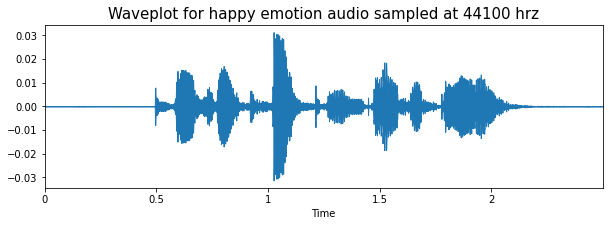

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


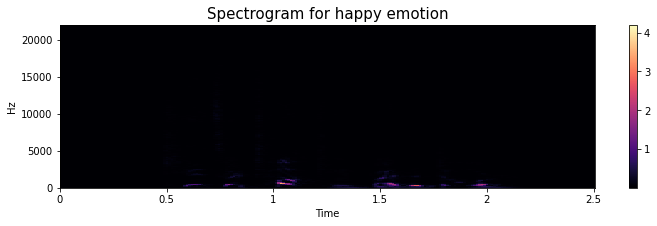

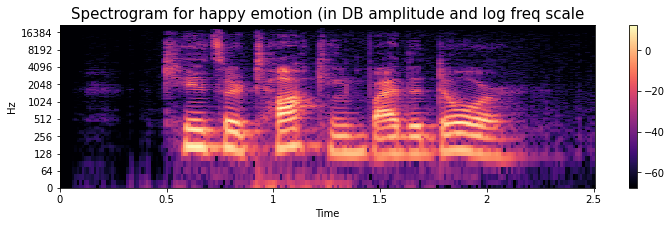

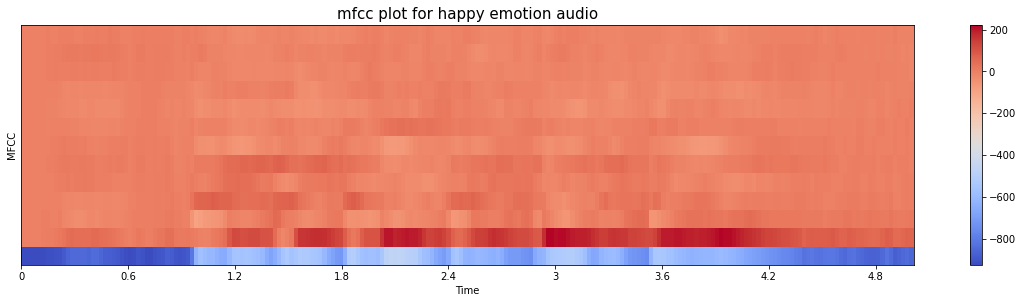

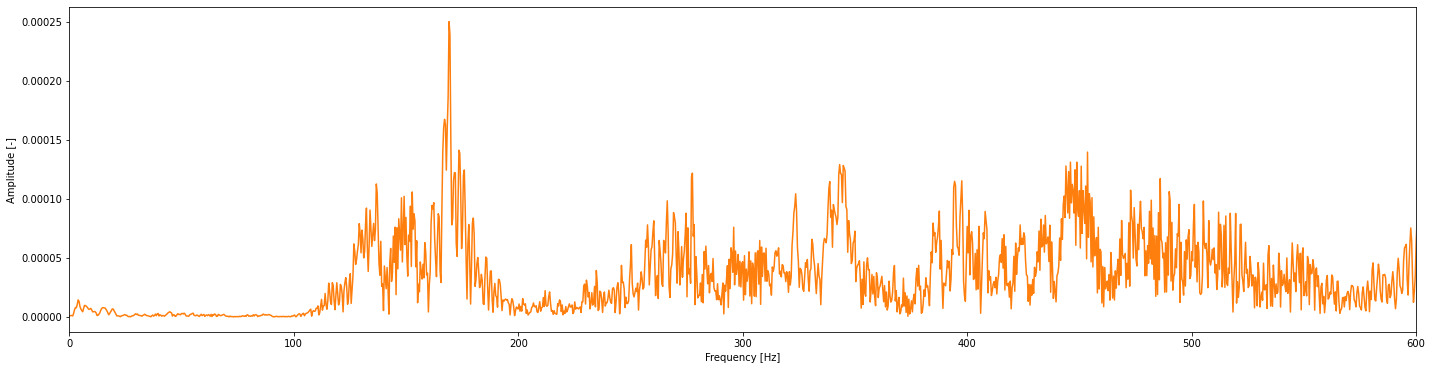

In [49]:
# Source - RAVDESS; Gender - Male; Emotion - Sad 
actor = "Actor_07/"
sample = "03-01-04-01-01-01-07.wav"
path = Ravdess_speech_sample + actor + sample
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

create_waveplot(path)
create_spectogram_nonlog(path)
create_spectogram(path)
mfcc_plot(path)
freq_plot(path)
ipd.Audio(path)

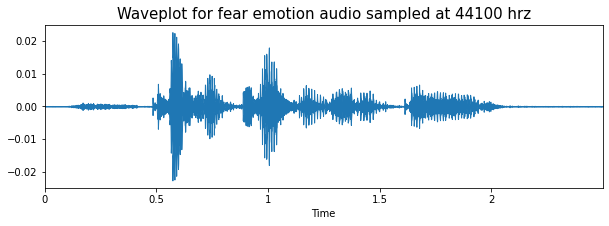

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


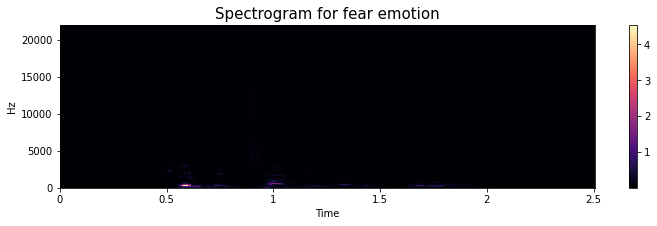

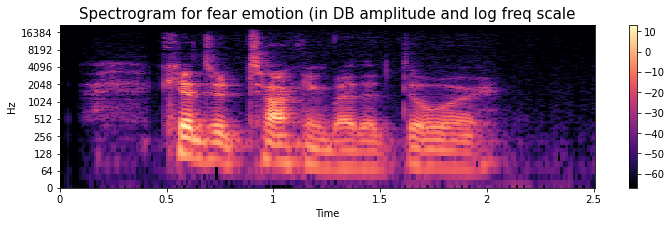

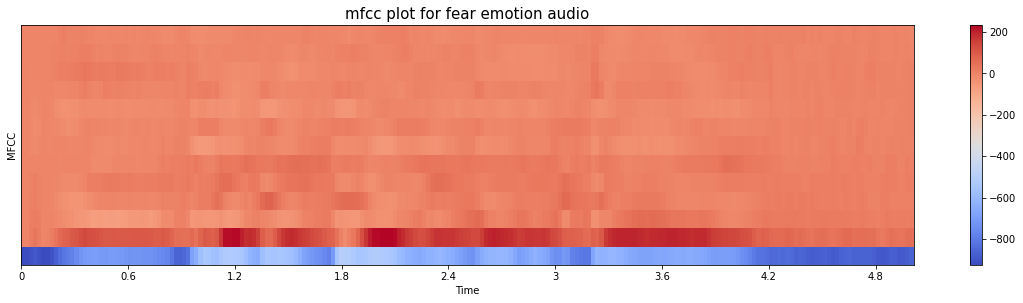

In [ ]:
# Source - RAVDESS; Gender - Male; Emotion - Disgust 
actor = "Actor_09/"
sample = "03-01-07-01-01-01-09.wav"
path = Ravdess_speech_sample + actor + sample
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

create_waveplot(path)
create_spectogram_nonlog(path)
create_spectogram(path)
mfcc_plot(path)
freq_plot(path)
ipd.Audio(path)

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Happy 
actor = "Actor_12/"
sample = "03-01-03-01-02-01-12.wav"
path = Ravdess_speech_sample + actor + sample
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

create_waveplot(path)
create_spectogram_nonlog(path)
create_spectogram(path)
mfcc_plot(path)
freq_plot(path)
ipd.Audio(path)

In [ ]:
# Source - RAVDESS; Gender - Male; Emotion - Happy 
actor = "Actor_11/"
sample = "03-01-03-01-02-02-11.wav"
path = Ravdess_speech_sample + actor + sample
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

create_waveplot(path)
create_spectogram_nonlog(path)
create_spectogram(path)
mfcc_plot(path)
freq_plot(path)
ipd.Audio(path)

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = Ravdess_speech_sample + "Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = Ravdess_speech_sample + "Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - happy 
path = Ravdess_speech_sample + "Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - happy 
path = Ravdess_speech_sample + "Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

# Processing

## Processing on one file as example

### Loading The Audio

In [ ]:
# Define file path for a single file.
sample_path = Ravdess_speech_sample + "Actor_02/03-01-01-01-01-01-02.wav"

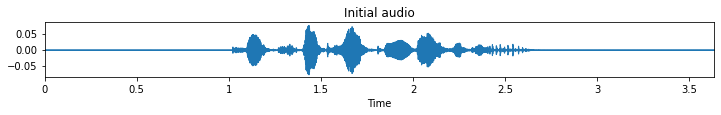

In [ ]:
# 1. Load the audio file into an 'AudioSegment' object, and extract the sample rate. 
#    'x' is an array of samples that is only relevant for visualization at this part.

rawsound = AudioSegment.from_file(sample_path )
x, sr = librosa.load(sample_path , sr = None)

plt.figure(figsize=(12,1))
librosa.display.waveplot(x, sr)
plt.title('Initial audio')

rawsound

### Normalize to +5.0 dBFS and transform to an array

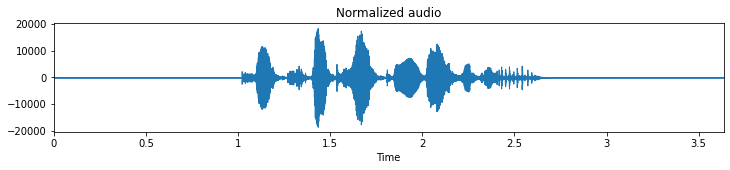

In [ ]:
# 2. Normalize to +5.0 dBFS, Transform audio signals to an array.

normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

plt.figure(figsize=(12,2))
librosa.display.waveplot(normal_x, sr)
plt.title('Normalized audio')

normalizedsound

### Trim Silence from the beginning and the end

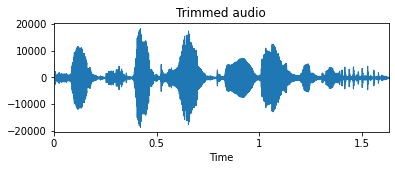

In [ ]:
# 3. Trim silence in the beginning and end.

xt, index = librosa.effects.trim(normal_x, top_db = 30)

plt.figure(figsize=(6,2))
librosa.display.waveplot(xt, sr)
plt.title('Trimmed audio')

ipd.display(ipd.Audio(data = xt, rate=sr))

### Padding for having equal lenth

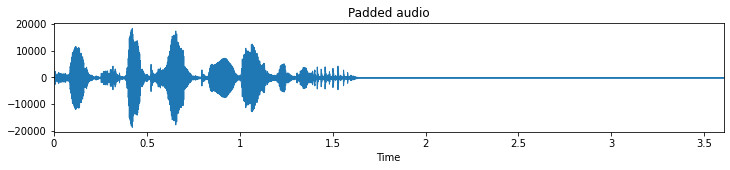

In [ ]:
# 4. Right-side padding for length equalization.
#    173056 = maximum lengthed audio (the maximum length is derived later)

padded_x = np.pad(xt, (0, 173056-len(xt)), 'constant')

plt.figure(figsize=(12,2))
librosa.display.waveplot(padded_x, sr)
plt.title('Padded audio')

ipd.display(ipd.Audio(data = padded_x, rate=sr))

### Noise Reduction

Note: although there is no noise to reduce from RAVDESS nor TESS databases, reduce_noise function by noisereduce library attributes a uniform stamper to the audio files.

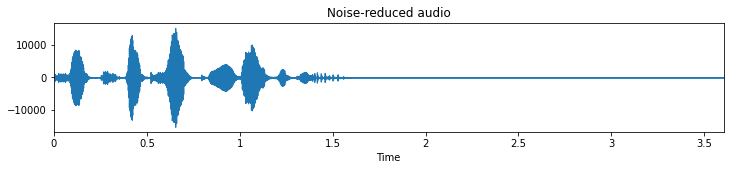

In [ ]:
# 5. Noise reduction
 

final_x = nr.reduce_noise(padded_x, sr = sr)



plt.figure(figsize=(12,2))
librosa.display.waveplot(final_x, sr)
plt.title('Noise-reduced audio')

ipd.display(ipd.Audio(data = final_x, rate=sr))

## Understanding Shapes of Files and Find the Padding Method

In [ ]:
# Sample of padding
i = 0
frame_length = 2048
total_length = 228864 
hop_length = 512
raw_folder_path = Ravdess

for subdir, dirs, files in os.walk(raw_folder_path):
  for file in files: 
        if (i < 20):
          current_path = os.path.join(subdir,file)
          # Fetch the sample rate.
          _, sr = librosa.load(path = current_path, sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
          # Load raw file
          rawsound = AudioSegment.from_file(current_path) 
          # Normalize the audio to +5.0 dBFS.
          # We skipped this part as we thought it might affect the emotion of the audio
          normalizedsound = effects.normalize(rawsound, headroom = 0) 
          # Transform the normalized audio to np.array of samples.
          normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
          # Trim silence from the beginning and the end.
          xt, index = librosa.effects.trim(normal_x, top_db=30)
          # Print raw file's shape
          print(f"original file: {xt},\n raw shape = {xt.shape}\n")
          padded_np = np.pad(xt, (0, total_length-len(xt)), 'constant')
          padded_keras = pad_sequences([xt], maxlen = total_length, padding='post', truncating='post', dtype='float32', value=0.0).reshape(-1,)
          # Ensuring both padding methods yield same values
          print(np.array_equal(padded_np,padded_keras))

          # noise reduce
          final_x = nr.reduce_noise(padded_keras, sr=sr)
          
          f1 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
          e_num = file[6:8] 
          e = emotion_encode(e_num)
          emotion = emotion_label(e)
          # Print path of file
          print(current_path)
          # Print emotion and label
          print(f"label and emotion: {e}, {emotion}")

          # Print padded and shape for understanding purpose
          print(f"numpy padded file: {padded_np},\n numpy padded shape = {padded_np.shape}")
          
          print(f"keras padded file: {padded_keras},\n keras padded shape = {padded_keras.shape}")
          print(f"final_x shape: {final_x.shape}") 
          print(f"feature shape: {f1.shape}\n\n\n")
          
          i += 1


original file: [  0.   0.   0. ... 440. 440. 385.],
 raw shape = (86016,)

True
/content/drive/MyDrive/datasets/speech/RAVDESS/data/Audio_Speech_Actors_01-24/Actor_18/03-01-01-01-01-01-18.wav
label and emotion: 7, neutral
numpy padded file: [0. 0. 0. ... 0. 0. 0.],
 numpy padded shape = (228864,)
keras padded file: [0. 0. 0. ... 0. 0. 0.],
 keras padded shape = (228864,)
final_x shape: (228864,)
feature shape: (13, 448)



original file: [   0.   50.  101. ... -304. -254. -304.],
 raw shape = (76288,)

True
/content/drive/MyDrive/datasets/speech/RAVDESS/data/Audio_Speech_Actors_01-24/Actor_18/03-01-01-01-02-01-18.wav
label and emotion: 7, neutral
numpy padded file: [  0.  50. 101. ...   0.   0.   0.],
 numpy padded shape = (228864,)
keras padded file: [  0.  50. 101. ...   0.   0.   0.],
 keras padded shape = (228864,)
final_x shape: (228864,)
feature shape: (13, 448)



original file: [  0. -49. -49. ... 145. 145. 193.],
 raw shape = (79360,)

True
/content/drive/MyDrive/datasets/spee

## Create DataFrame of Paths and Emotions (Labels)

In [ ]:
# Create dataframe from paths and emotions (labels)

file_emotion = []
file_label = []
file_path = []

for subdir, dirs, files in os.walk(Ravdess):
  for file in files: 
    file_path.append(Ravdess + "/" + file)
    loc = Ravdess + file
    # storing file emotions
    e_num = loc[len(Ravdess) + 6: len(Ravdess) + 8] 
    e = emotion_encode(e_num)
    file_label.append(e)
    file_emotion.append(emotion_label(e))


# dataframe for emotion of files
label_df = pd.DataFrame(file_emotion, columns=['emotion'])
        
# dataframe for emotion label of files
emotion_df = pd.DataFrame(file_label, columns=['label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
ravdess_df = pd.concat([emotion_df, label_df, path_df], axis=1)
from pathlib import Path  
ravdess_df.to_csv(path_or_buf = df_path, index=False)

In [ ]:
ravdess_df

label   emotion                                               path
0         7   neutral  /content/drive/MyDrive/datasets/speech/RAVDESS...
1         7   neutral  /content/drive/MyDrive/datasets/speech/RAVDESS...
2         7   neutral  /content/drive/MyDrive/datasets/speech/RAVDESS...
3         7   neutral  /content/drive/MyDrive/datasets/speech/RAVDESS...
4         0      calm  /content/drive/MyDrive/datasets/speech/RAVDESS...
...     ...       ...                                                ...
1435      6  suprised  /content/drive/MyDrive/datasets/speech/RAVDESS...
1436      6  suprised  /content/drive/MyDrive/datasets/speech/RAVDESS...
1437      6  suprised  /content/drive/MyDrive/datasets/speech/RAVDESS...
1438      6  suprised  /content/drive/MyDrive/datasets/speech/RAVDESS...
1439      6  suprised  /content/drive/MyDrive/datasets/speech/RAVDESS...

[1440 rows x 3 columns]

In [ ]:
ravdess_df.sort_values('emotion')

label   emotion                                               path
634       3     angry  /content/drive/MyDrive/datasets/speech/RAVDESS...
756       3     angry  /content/drive/MyDrive/datasets/speech/RAVDESS...
755       3     angry  /content/drive/MyDrive/datasets/speech/RAVDESS...
753       3     angry  /content/drive/MyDrive/datasets/speech/RAVDESS...
752       3     angry  /content/drive/MyDrive/datasets/speech/RAVDESS...
...     ...       ...                                                ...
836       6  suprised  /content/drive/MyDrive/datasets/speech/RAVDESS...
835       6  suprised  /content/drive/MyDrive/datasets/speech/RAVDESS...
834       6  suprised  /content/drive/MyDrive/datasets/speech/RAVDESS...
893       6  suprised  /content/drive/MyDrive/datasets/speech/RAVDESS...
1439      6  suprised  /content/drive/MyDrive/datasets/speech/RAVDESS...

[1440 rows x 3 columns]

In [ ]:
ravdess_df['label'].value_counts()

0    192
1    192
3    192
2    192
4    192
5    192
6    192
7     96
Name: label, dtype: int64

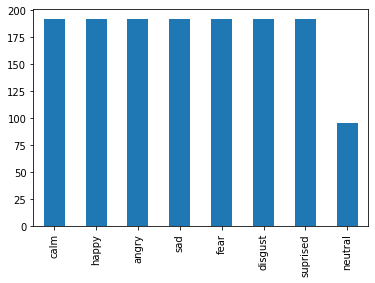

In [ ]:
ravdess_df['emotion'].value_counts().plot(kind='bar')

In [ ]:
ravdess_df.iloc[0]['path']

'/content/drive/MyDrive/datasets/speech/RAVDESS/data/Audio_Speech_Actors_01-24/03-01-01-01-01-01-18.wav'

In [ ]:
Ravdess

'/content/drive/MyDrive/datasets/speech/RAVDESS/data/Audio_Speech_Actors_01-24'

## Find Maximum Padding of Samples for Padding Purposes

Normalize to +5.0 dBFS and transform to an array


In [ ]:
# Maximum samples count for padding purposes.

sample_lengths = []

for subdir, dirs, files in os.walk(Ravdess):
  for file in tqdm(files): 
    e_num = file[6:8]
    if e_num == "01":
            continue
    current_path = os.path.join(subdir,file)
    x, sr = librosa.load(path = current_path, sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))

0it [00:00, ?it/s]
100%|██████████| 60/60 [00:12<00:00,  4.94it/s]

Maximum sample length: 204288


In [ ]:
print('Maximum sample length:', np.max(sample_lengths))

Maximum sample length: 204288


In [ ]:
# Maximum samples count for padding purposes.

sample_lengths = []

for subdir, dirs, files in os.walk(Ravdess):
  for file in tqdm(files): 
    current_path = os.path.join(subdir,file)
    e_num = file[6:8]
    if e_num == "01":
            continue
    rawsound = AudioSegment.from_file(current_path)
    normalizedsound = effects.normalize(rawsound, headroom = 0) 
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32') 
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))

0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 141.39it/s]

Maximum sample length: 228864


In [ ]:
print('Maximum sample length:', np.max(sample_lengths))

Maximum sample length: 228864


Maximum sample length: 228864

## Processing audio files, extract features, prepare for feeding to model

**Steps:**

**1. Processing**
1. Loading The Audio files
2. Normalize to +5.0 dBFS and transform to an array
3. Trim Silence from the beginning and the end
4. Padding for having equal lenth
5. Noise Reduction

**2. Feature Extraction**
Extract the following features using *librosa*:
* MFCC
* RMS: Energy - Root Mean Square
* ZCR

**3. Adjust to 3D shape for RNN**
Map the processed format's shape, i.e., `input_shape` to `(batch, timesteps, feature)`
  
**4. Concatenate all features and store in files of X and Y (features and labels)**

**5. Create and Store Training, Validation and Test Files**



### 1. Processing & 2. Feature Extraction

In [ ]:

# Initialize data lists
rms = []
zcr = []
mfcc = []
chroma = []
mel = []

emotions = []
#lens = []

# Initialize variables

# Computed previously 
total_length = 228864 
frame_length = 2048
hop_length = 512
raw_folder_path = Ravdess


for subdir, dirs, files in os.walk(raw_folder_path):
  for file in tqdm(files): 
    # Fetch the current file's directory
    current_path = os.path.join(subdir,file)

    # Fetch the part of file that representes the emotion
    e_num = file[6:8] 

    # Removing files with label "neutral" as they are imbalanced w.r.t other labels
    if e_num == "01":
            continue


    # Fetch the sample rate.
    # "sr" denotes the sample rate. "_" is the signal but it is dismissed
    _, sr = librosa.load(path = current_path, sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
    rawsound = AudioSegment.from_file(current_path) 
    # Normalize the audio to +5.0 dBFS.
    normalizedsound = effects.normalize(rawsound, headroom = 0) 
    # Transform the normalized audio to np.array of samples.
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    # Pad for duration equalization.
    padded_x = pad_sequences([xt], maxlen = total_length, padding='post', truncating='post', dtype='float32', value=0.0).reshape(-1,)
    # Noise reduction.
    final_x = nr.reduce_noise(padded_x, sr=sr)

    # Features extraction 
    f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # RMS
    f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
    f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
    f4 = librosa.feature.chroma_stft(final_x, sr=sr, hop_length = hop_length) # Chroma
    f5 = librosa.feature.melspectrogram(final_x, sr=sr, hop_length = hop_length) # Mel Scale

    
    # Fetch the emotion's label (number) using the encoding function we defined "emotion_encode"
    # This would be our (multiclass) target that we aim at predicting
    e = emotion_encode(e_num)
    # Fetch the emotion's label but this is only for our understanding and won't be added anywehere
    emotion = emotion_label(e)

                     

    # Storing features in their corresponding lists
    rms.append(f1)
    zcr.append(f2)
    mfcc.append(f3)
    chroma.append(f4)
    mel.append(f5)
    # Storing label
    emotions.append(e) 

toc = time.perf_counter()

0it [00:00, ?it/s]
100%|██████████| 60/60 [00:16<00:00,  3.70it/s]


In [ ]:
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 11.3734 minutes


### 3. Adjust Shapes

In [ ]:
# Convert to array
f_rms = np.asarray(rms).astype('float32')
f_zcr = np.asarray(zcr).astype('float32')
f_mfccs = np.asarray(mfcc).astype('float32')
f_chroma = np.asarray(chroma).astype('float32')
f_mel = np.asarray(mel).astype('float32')


In [ ]:
f_rms.shape

(1344, 1, 448)

In [ ]:
f_rms[0].shape

(1, 448)

In [ ]:

# Adjusting features shape to the 3D format: (batch, timesteps, feature)
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.swapaxes(f_mfccs,1,2)
f_chroma = np.swapaxes(f_chroma,1,2)
f_mel = np.swapaxes(f_mel,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)
print('CHROMA shape:',f_chroma.shape)
print('MEL shape:',f_mel.shape)

ZCR shape: (1344, 448, 1)
RMS shape: (1344, 448, 1)
MFCCs shape: (1344, 448, 13)
CHROMA shape: (1344, 448, 12)
MEL shape: (1344, 448, 128)


### 4. Concatenate all features and store files

In [ ]:
# Concatenating all features to 'X' variable.
X = f_mfccs
# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [ ]:
X.shape

(1344, 448, 13)

In [ ]:
Y.shape

(1344, 1)

In [ ]:
X

array([[[ 5.03845612e+02, -2.58249321e+01, -3.30254822e+01, ...,
         -4.15372705e+00,  1.12068596e+01,  4.12284732e-02],
        [ 5.61167969e+02, -6.11955032e+01, -5.79409256e+01, ...,
         -1.32235126e+01,  8.35187817e+00,  3.85092926e+00],
        [ 5.66962280e+02, -6.48484650e+01, -5.96132736e+01, ...,
         -1.43673964e+01,  8.84561539e+00,  4.62950802e+00],
        ...,
        [ 4.57112854e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.57112854e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.57112854e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 5.13244507e+02, -1.80649948e+01, -5.22750626e+01, ...,
         -4.85177517e+00, -6.70467567e+00,  1.29680119e+01],
        [ 5.95687988e+02, -6.31637650e+01, -1.00957611e+02, ...,
          3.81166130e-01, -2.05730400e

In [ ]:
Y

array([[0],
       [0],
       [0],
       ...,
       [6],
       [6],
       [6]], dtype=int8)

In [ ]:
# Save X,Y arrays as lists to json files.

processed_path = Ravdess_processed

x_data = X.tolist() 

x_path = processed_path + "X_features_MFCC.json" # FILE SAVE PATH
#x_path = '/content/drive/MyDrive/datasets/speech/RAVDESS/processedData/X_features.json'
dump(obj = x_data, fp = x_path)

y_data = Y.tolist() 
y_path =  processed_path + "Y_labels.json" # FILE SAVE PATH
dump(obj = y_data, fp = y_path)

'[[0], [0], [0], [1], [0], [1], [0], [0], [1], [0], [1], [1], [0], [1], [3], [1], [3], [2], [2], [2], [2], [2], [2], [1], [2], [2], [3], [4], [3], [4], [4], [3], [3], [3], [4], [3], [4], [5], [5], [5], [5], [5], [4], [4], [5], [5], [4], [5], [6], [6], [6], [6], [6], [6], [6], [6], [0], [0], [1], [0], [0], [0], [0], [0], [1], [0], [1], [2], [2], [1], [2], [1], [1], [2], [1], [2], [2], [2], [1], [3], [3], [3], [4], [3], [3], [3], [4], [4], [3], [4], [3], [2], [5], [5], [6], [5], [5], [4], [4], [5], [5], [4], [5], [5], [4], [6], [6], [6], [6], [6], [6], [6], [0], [0], [1], [0], [0], [0], [0], [0], [1], [1], [1], [0], [2], [1], [2], [1], [2], [2], [2], [2], [2], [2], [1], [1], [3], [3], [3], [4], [4], [3], [3], [4], [3], [3], [4], [4], [4], [4], [3], [6], [5], [6], [6], [5], [5], [5], [5], [4], [5], [5], [5], [6], [6], [6], [6], [6], [0], [0], [0], [0], [0], [0], [0], [2], [1], [1], [1], [1], [2], [2], [2], [1], [1], [0], [1], [1], [2], [3], [3], [3], [3], [2], [3], [3], [2], [2], [3], [4]

In [ ]:
#making sure there is not "neutral" label in Y (labels)
all(Y != 7)

True

In [ ]:
unique, counts = np.unique(Y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 192]
 [  1 192]
 [  2 192]
 [  3 192]
 [  4 192]
 [  5 192]
 [  6 192]]


All classes have the same number of counts now

In [ ]:
np.histogram(Y, bins=7)

(array([192, 192, 192, 192, 192, 192, 192]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]))

In [ ]:
x_path

'/content/drive/MyDrive/datasets/speech/RAVDESS/processedData/onlySpeech/X_features_MFCC.json'

In [ ]:
# Load X,Y json files back into lists, convert to np.arrays

processed_path = Ravdess_processed
x_path = processed_path + "X_features.json" # FILE SAVE PATH
y_path =  processed_path + "Y_labels.json" # FILE SAVE PATH

X = load(x_path)
X = np.asarray(X, dtype = 'float32')

Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

### 5. Create and Store Training, Validation and Test Files

In [ ]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [ ]:
#Normalize using StdScaler

#scaler = StandardScaler()

#X_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
#X_val = scaler.fit_transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)
#X_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [ ]:
X_train = x_train
X_val = x_val
X_test = x_test

In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(X_test))

(1176, 448, 153)
(116, 448, 153)
(52, 448, 153)


In [ ]:
## shape of inputs for the LSTM model
X_train.shape[1:3]

(448, 153)

In [ ]:
# y_train, y_val, and y_test shape check.
print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(1176, 1)
(116, 1)
(52, 1)


In [ ]:
# Save x_test, y_test to JSON.

x_test_path = Ravdess_processed + 'x_test_data.json'
dump(obj = X_test, fp = x_test_path)

y_test_path = Ravdess_processed + 'y_test_data.json'
dump(obj = y_test, fp = y_test_path)

'{"__ndarray__": [[0], [2], [6], [5], [3], [3], [2], [4], [4], [3], [6], [2], [0], [5], [0], [5], [0], [0], [6], [3], [5], [3], [3], [3], [4], [2], [5], [5], [2], [1], [4], [2], [6], [3], [2], [4], [0], [0], [3], [4], [6], [1], [0], [3], [2], [0], [5], [2], [4], [5], [0], [5]], "dtype": "int8", "shape": [52, 1], "Corder": true}'

In [ ]:
x_train

array([[[ 1.14567719e+02, -1.80214238e+00, -1.07756805e+01, ...,
          2.70546317e+00,  8.23085189e-01,  5.64413607e-01],
        [ 3.13837372e+02, -7.57997894e+01, -1.19722580e+02, ...,
          4.19175720e+01,  5.05853033e+00,  1.06767952e+00],
        [ 3.78867249e+02, -1.11395401e+02, -1.32633270e+02, ...,
          3.70259430e+02,  2.81230087e+01,  4.21197701e+00],
        ...,
        [ 1.06207146e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.06207146e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.06207146e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.75022263e+02, -2.15490665e+01, -4.58573914e+01, ...,
          1.25357640e+00,  6.35412395e-01,  3.61624211e-01],
        [ 2.33897797e+02, -6.12694550e+01, -6.89778442e+01, ...,
          9.54192448e+00,  1.39220750e

In [ ]:
X_train

array([[[ 1.14567719e+02, -1.80214238e+00, -1.07756805e+01, ...,
          2.70546317e+00,  8.23085189e-01,  5.64413607e-01],
        [ 3.13837372e+02, -7.57997894e+01, -1.19722580e+02, ...,
          4.19175720e+01,  5.05853033e+00,  1.06767952e+00],
        [ 3.78867249e+02, -1.11395401e+02, -1.32633270e+02, ...,
          3.70259430e+02,  2.81230087e+01,  4.21197701e+00],
        ...,
        [ 1.06207146e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.06207146e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.06207146e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.75022263e+02, -2.15490665e+01, -4.58573914e+01, ...,
          1.25357640e+00,  6.35412395e-01,  3.61624211e-01],
        [ 2.33897797e+02, -6.12694550e+01, -6.89778442e+01, ...,
          9.54192448e+00,  1.39220750e

In [ ]:
X_test

array([[[ 2.50573685e+02, -9.56819439e+00, -4.65111198e+01, ...,
          4.57069844e-01,  3.76658171e-01,  2.80703843e-01],
        [ 3.34632111e+02, -4.61957359e+01, -1.00465584e+02, ...,
          2.90848327e+00,  1.13282788e+00,  6.84970260e-01],
        [ 3.74538971e+02, -7.67487030e+01, -1.04489975e+02, ...,
          5.06001282e+01,  6.67080212e+00,  2.07459569e+00],
        ...,
        [ 2.09221512e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.09221512e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.09221512e+02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 3.02554901e+02,  6.32570534e+01,  4.91255646e+01, ...,
          1.95833721e+01,  3.02050519e+00,  2.03637242e+00],
        [ 3.64901886e+02,  1.17485367e+02,  5.67912521e+01, ...,
          2.43618908e+01,  5.47052479e